In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

### Loading Dataset (Mall Customer)

In [2]:
df=pd.read_csv("Mall_Customers.csv")

In [3]:
df.shape

(200, 5)

In [4]:
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [6]:
df.describe

<bound method NDFrame.describe of      CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0             1    Male   19                  15                      39
1             2    Male   21                  15                      81
2             3  Female   20                  16                       6
3             4  Female   23                  16                      77
4             5  Female   31                  17                      40
..          ...     ...  ...                 ...                     ...
195         196  Female   35                 120                      79
196         197  Female   45                 126                      28
197         198    Male   32                 126                      74
198         199    Male   32                 137                      18
199         200    Male   30                 137                      83

[200 rows x 5 columns]>

In [7]:
df.dtypes

CustomerID                 int64
Genre                     object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

In [8]:
df.isna().sum()

CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [9]:
print("Duplicates:", df.duplicated().sum())

Duplicates: 0


### Standardize column names 

In [10]:
def normalize_col(c):
    return (
        str(c)
        .strip()
        .lower()
        .replace(" ", "_")
        .replace("-", "_")
        .replace("(", "")
        .replace(")", "")
        .replace("$", "s")
        .replace("/", "_")
    )


In [11]:
original_cols = df.columns.tolist()
df.columns = [normalize_col(c) for c in df.columns]
# fix possible "genre" typo to "gender"
df.columns = [c.replace("genre", "gender") for c in df.columns]


In [12]:
print("\nOriginal columns:", original_cols)
print("Normalized columns:", df.columns.tolist())



Original columns: ['CustomerID', 'Genre', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']
Normalized columns: ['customerid', 'gender', 'age', 'annual_income_ks', 'spending_score_1_100']


### Drop Duplicates(if any)

In [13]:
before = len(df)
df = df.drop_duplicates().copy()
after = len(df)
if before != after:
    print(f"Removed {before - after} duplicate rows.")

### Auto-detect key columns 
(robust to slight name variations)

In [14]:
def find_col(cols, keywords):
    for c in cols:
        s = c.lower()
        if all(k in s for k in keywords):
            return c
    return None

cols = df.columns.tolist()
age_col = find_col(cols, ["age"])
income_col = find_col(cols, ["income"]) or find_col(cols, ["annual", "income"])
spend_col = find_col(cols, ["spending", "score"]) or find_col(cols, ["spending"])
gender_col = find_col(cols, ["gender"])  # optional
id_col = find_col(cols, ["customer", "id"]) or find_col(cols, ["id"])

print("\nDetected columns:")
print("  age     ->", age_col)
print("  income  ->", income_col)
print("  spend   ->", spend_col)
print("  gender  ->", gender_col)
print("  id      ->", id_col)

# Minimal check: we need at least age, income, spending
needed = [age_col, income_col, spend_col]
if any(c is None for c in needed):
    raise ValueError("Could not auto-detect one of [age, income, spending]. Please rename columns or set them manually.")


Detected columns:
  age     -> age
  income  -> annual_income_ks
  spend   -> spending_score_1_100
  gender  -> gender
  id      -> customerid


### Encode gender (robust mapping)

In [15]:
if gender_col is not None:
    if df[gender_col].dtype == object:
        # Map by first letter
        df[gender_col] = df[gender_col].astype(str).str.strip().str[0].str.upper().map({"M":1, "F":0})
        df[gender_col] = df[gender_col].fillna(-1)
    else:
        # Assume already numeric
        df[gender_col] = df[gender_col].fillna(-1)

In [16]:
df.head()


,customerid,gender,age,annual_income_ks,spending_score_1_100
0,1,1,19,15,39
1,2,1,21,15,81
2,3,0,20,16,6
3,4,0,23,16,77
4,5,0,31,17,40


### Drop column ID
(not used in custering)


In [17]:
if id_col is not None:
    try:
        df = df.drop(columns=[id_col])
    except Exception:
        pass

### Build Feature Matrix:

#### Feature Selection / Feature List
List of feature columns we want to use in the model



In [18]:

feature_cols = [age_col, income_col, spend_col, gender_col]


#### Convert Data to Numeric / Array
Extract these columns from the DataFrame and convert to a NumPy array
Also make sure all values are of type float (required for ML models)



In [19]:

X = df[feature_cols].to_numpy().astype(float)


#### Scaling / Normalization
Create a StandardScaler object for scaling the features
StandardScaler will normalize features so that they have mean=0 and std=1



In [20]:

scaler = StandardScaler()




Fit the scaler to X and transform X to scaled values
This produces X_scaled, which is ready for machine learning


In [21]:

X_scaled = scaler.fit_transform(X)

# Print the feature columns used
print("Feature columns:", feature_cols)

# Print the shape of the scaled features array (rows, columns)
print("Scaled X shape:", X_scaled.shape)


Feature columns: ['age', 'annual_income_ks', 'spending_score_1_100', 'gender']
Scaled X shape: (200, 4)


### Exploratory Data Analysis

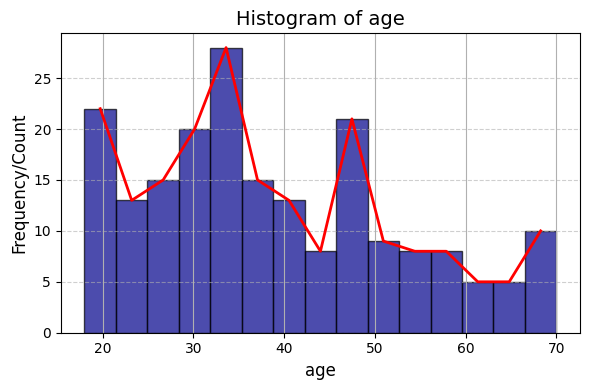

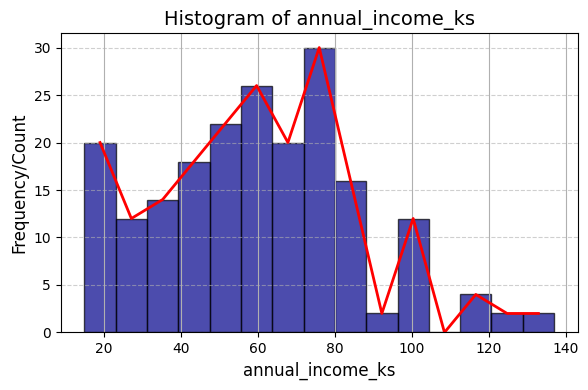

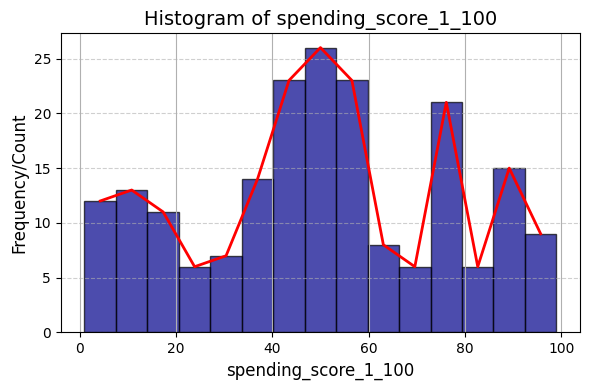

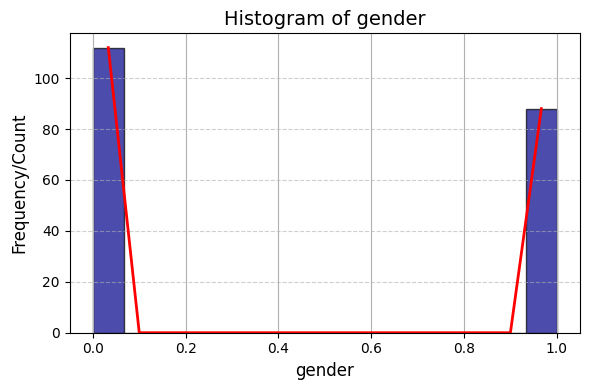

In [22]:

for col in feature_cols:
    plt.figure(figsize=(6, 4))
    
    # Plot histogram and get counts and bins
    counts, bins, _ = plt.hist(df[col], bins=15, color='darkblue', edgecolor='black', alpha=0.7)
    
    # Calculate bin centers
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    
    # Plot simple trend line showing rise/fall
    plt.plot(bin_centers, counts, color='red', linewidth=2)  # red line as trend
    
    # Add title and labels
    plt.title(f"Histogram of {col}", fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Frequency/Count", fontsize=12)
    
    # Show grid
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    
    # Adjust layout and show
    plt.grid(True)

    plt.tight_layout()
    plt.show()


### Pairwise Scatters:

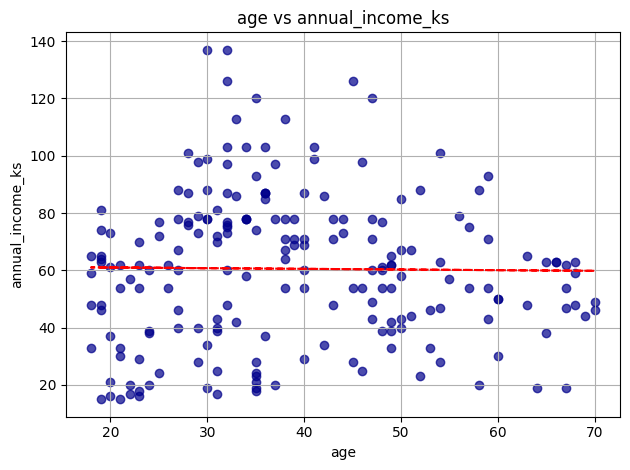

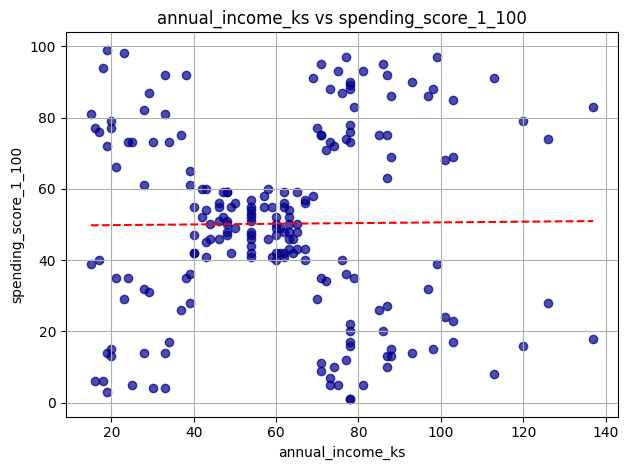

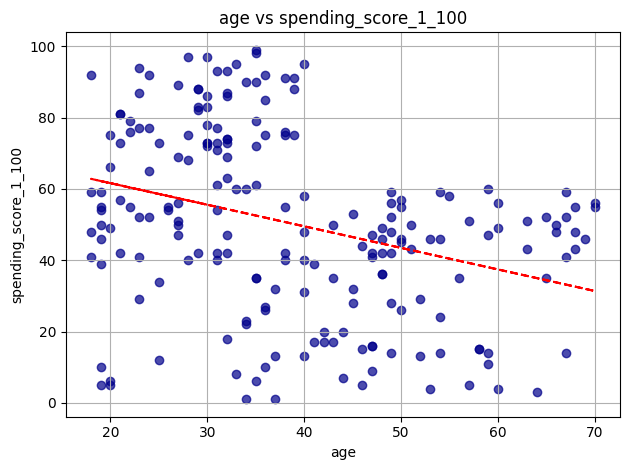

In [23]:
pairs = [(age_col, income_col), (income_col, spend_col), (age_col, spend_col)]
for xcol, ycol in pairs:
    plt.figure()
    plt.scatter(df[xcol], df[ycol], alpha=0.7,color='darkblue')
    plt.title(f"{xcol} vs {ycol}")
    plt.xlabel(xcol,fontsize=10)
    plt.ylabel(ycol,fontsize=10)
    plt.grid(True)
    
    #trend line:
    m, b = np.polyfit(df[xcol], df[ycol], 1)
    plt.plot(df[xcol], m*df[xcol] + b, color='red', linestyle='--')
    plt.tight_layout()
    plt.show()

### K using Elbow + Silhouette
Goal: Find best number of clusters (K).

Elbow: Plot K vs inertia → pick the "elbow" where the curve flattens.

Silhouette: Higher score (closer to 1) = better cluster separation.

Combine both: Use Elbow to get a range, Silhouette to pick the best K.


In [24]:
k_range = range(2, 11)
inertias = []
silhouettes = []

# Reproducibility
SEED = 42
np.random.seed(SEED)
k_range = range(2, 11)
inertias = []
silhouettes = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=SEED, n_init="auto")
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

### plotting Elbow - inertia 

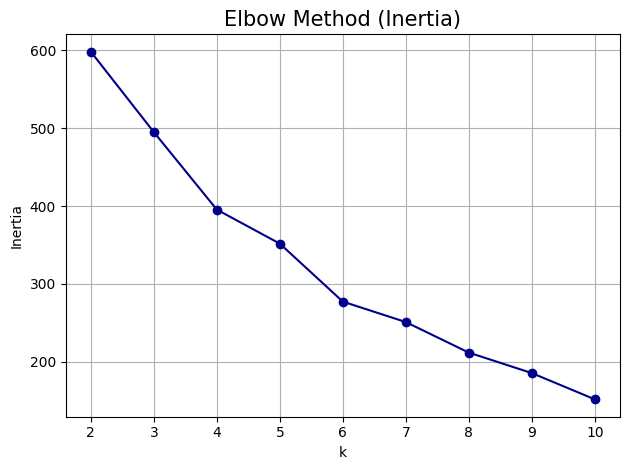

In [25]:
plt.figure()
plt.plot(list(k_range), inertias, marker="o", color="darkblue")
plt.title("Elbow Method (Inertia)", fontsize=15)
plt.xlabel("k",fontsize=10) 
plt.grid(True)
plt.ylabel("Inertia", fontsize=10)
plt.tight_layout()
plt.show()

##### Lower inertia = better clustering (for Elbow method).

inertias → for Elbow method (sum of distances inside clusters)

silhouettes → for Silhouette method (how well clusters are separated)

###  Plot silhouette

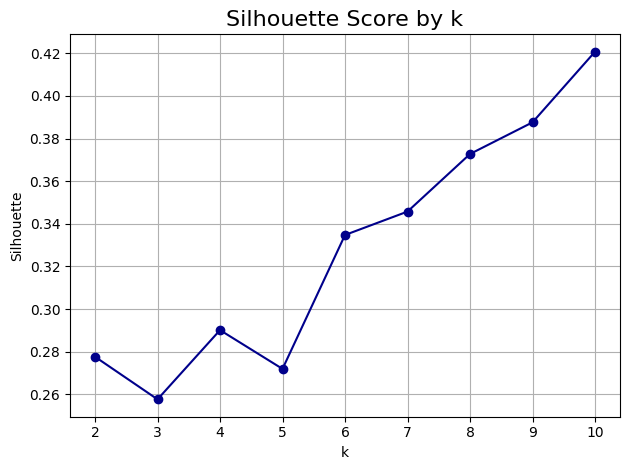

In [26]:

plt.figure()
plt.plot(list(k_range), silhouettes, marker="o",color="darkblue")
plt.title("Silhouette Score by k",fontsize=16)
plt.xlabel("k",fontsize=10)
plt.ylabel("Silhouette",fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
best_k_sil = int(k_range[int(np.argmax(silhouettes))])
print("Best k by silhouette:", best_k_sil)

Best k by silhouette: 10


In [28]:
BEST_K = best_k_sil

so , We will be using silhouette's best k

### Visualization of Clusters

In [29]:
km = KMeans(n_clusters=BEST_K, random_state=SEED, n_init="auto")
labels = km.fit_predict(X_scaled)
df["cluster"] = labels

#back to original scale:

centroids = scaler.inverse_transform(km.cluster_centers_)
print("Cluster sizes:")
print(pd.Series(labels).value_counts().sort_index())

Cluster sizes:
0    26
1    24
2    14
3    21
4    26
5    19
6    25
7    18
8    13
9    14
Name: count, dtype: int64


#### Visulaizing Clusters 

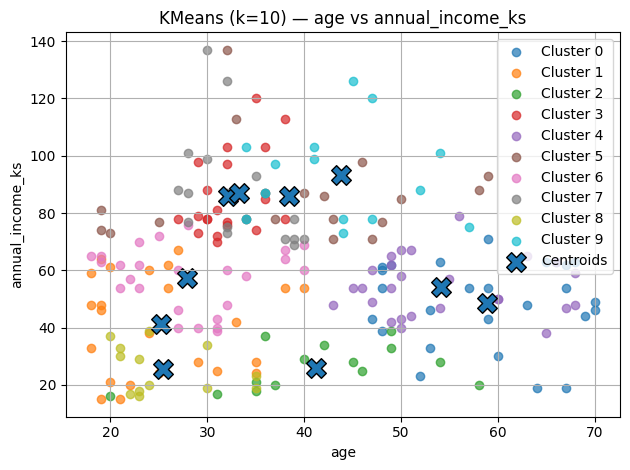

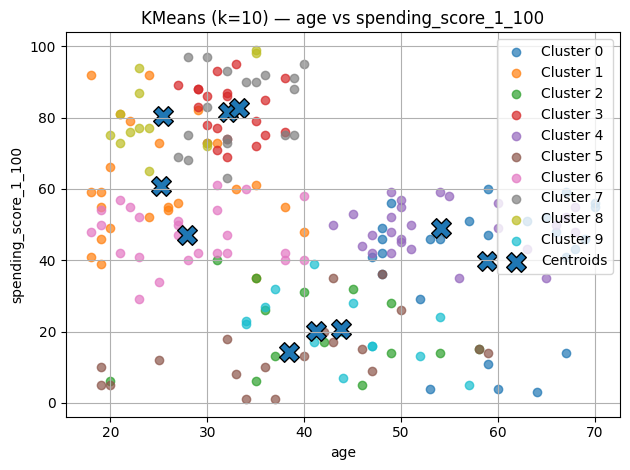

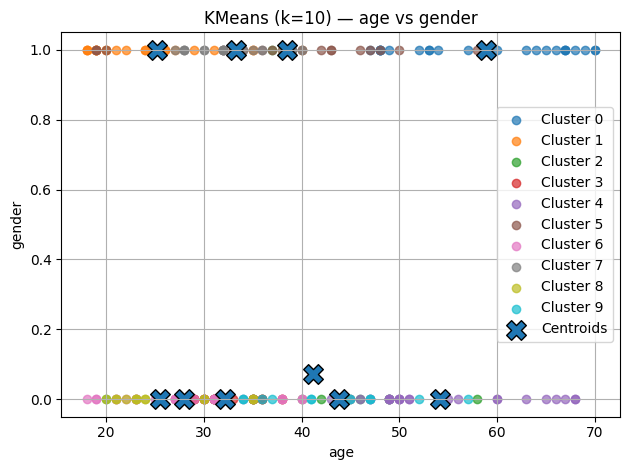

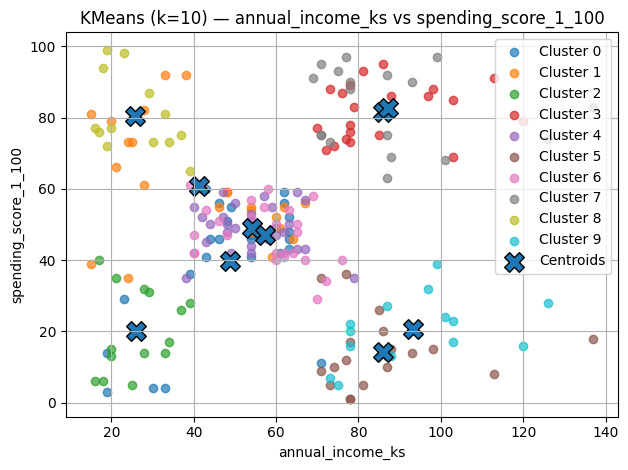

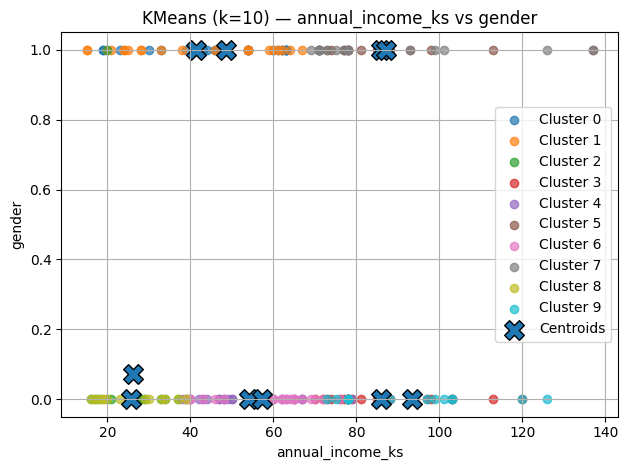

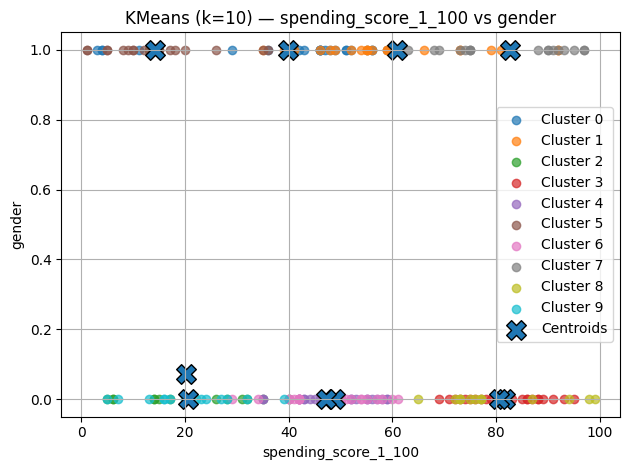

In [44]:
from itertools import combinations
import matplotlib.pyplot as plt

feature_cols_plus_gender = [age_col, income_col, spend_col, gender_col]
pairs = list(combinations(feature_cols_plus_gender, 2))
for xcol, ycol in pairs:
    plt.figure()
    for cl in np.unique(labels):
        mask = labels == cl
        plt.scatter(df.loc[mask, xcol], df.loc[mask, ycol], alpha=0.7, label=f"Cluster {cl}")
    # Plot centroids (converted to original scale)
    # Map centroid columns to indices in feature_cols
    x_idx = feature_cols.index(xcol)
    y_idx = feature_cols.index(ycol)
    plt.scatter(centroids[:, x_idx], centroids[:, y_idx], marker="X", s=200, edgecolor="k", label="Centroids")
    plt.title(f"KMeans (k={BEST_K}) — {xcol} vs {ycol}")
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


#### Cluster Profiling

In [32]:
profile_cols = feature_cols.copy()
summary = df.groupby("cluster")[feature_cols].agg(["mean", "median", "min", "max", "count"])
display(summary)


age                      annual_income_ks                  \
              mean median min max count             mean median min  max   
cluster                                                                    
0        58.846154   59.0  47  70    26        48.692308   51.5  19   71   
1        25.250000   24.0  18  40    24        41.250000   44.0  15   67   
2        41.214286   41.0  20  58    14        26.071429   26.5  16   39   
3        32.190476   32.0  27  38    21        86.047619   79.0  70  120   
4        54.153846   50.5  43  68    26        54.230769   54.0  38   79   
5        38.473684   40.0  19  59    19        85.894737   81.0  71  137   
6        27.960000   27.0  18  40    25        57.360000   60.0  39   76   
7        33.277778   32.0  27  40    18        87.111111   82.5  69  137   
8        25.461538   23.0  20  35    13        25.692308   23.0  16   39   
9        43.785714   44.0  34  57    14        93.285714   92.5  73  126   

              spending_score_1_100                         gender             \
        count                 mean median min max count      mean median min   
cluster                                                                        
0          26            39.846154   46.0   3  60    26  1.000000    1.0   1   
1          24            60.916667   57.5  35  92    24  1.000000    1.0   1   
2          14            20.142857   16.0   5  40    14  0.071429    0.0   0   
3          21            81.666667   83.0  69  95    21  0.000000    0.0   0   
4          26            48.961538   49.5  35  59    26  0.000000    0.0   0   
5          19            14.210526   13.0   1  36    19  1.000000    1.0   1   
6          25            47.120000   47.0  29  61    25  0.000000    0.0   0   
7          18            82.666667   85.5  63  97    18  1.000000    1.0   1   
8          13            80.538462   77.0  65  99    13  0.000000    0.0   0   
9          14            20.642857   21.0   5  39    14  0.000000    0.0   0   

                   
        max count  
cluster            
0         1    26  
1         1    24  
2         1    14  
3         0    21  
4         0    26  
5         1    19  
6         0    25  
7         1    18  
8         0    13  
9         0    14

In [33]:

# Average spending per cluster
avg_spend = df.groupby("cluster")[spend_col].mean().sort_values(ascending=False)
print("\nAverage spending score per cluster:")
print(avg_spend)





Average spending score per cluster:
cluster
7    82.666667
3    81.666667
8    80.538462
1    60.916667
4    48.961538
6    47.120000
0    39.846154
9    20.642857
2    20.142857
5    14.210526
Name: spending_score_1_100, dtype: float64


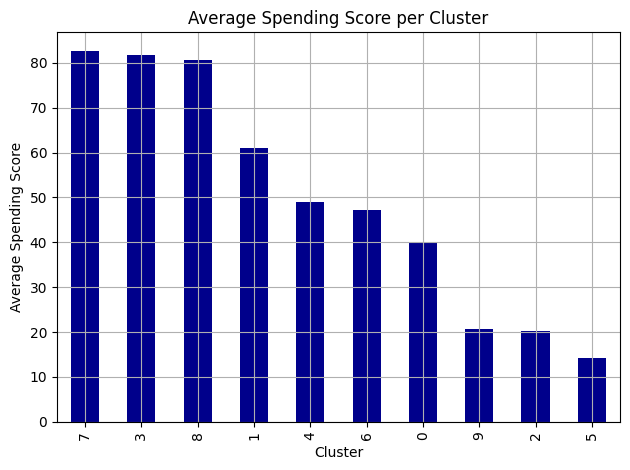

In [43]:
plt.figure()
avg_spend.plot(kind="bar", color='darkblue')
plt.title("Average Spending Score per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Spending Score")
plt.grid(True)
plt.tight_layout()
plt.show()

### DBSCAN 

In [35]:
# Simple grid search for DBSCAN over eps and min_samples
eps_grid = np.linspace(0.3, 1.5, 9)   # tweak if needed
min_samples_grid = [3, 4, 5, 6, 8, 10]
best_score = -1
best_params = None
best_labels = None
for eps in eps_grid:
    for ms in min_samples_grid:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels_db = db.fit_predict(X_scaled)
        # silhouette requires at least 2 clusters and no all -1
        n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
        if n_clusters >= 2 and np.unique(labels_db).size > 1 and np.any(labels_db != -1):
            try:
                score = silhouette_score(X_scaled, labels_db)
            except Exception:
                score = -1
            if score > best_score:
                best_score = score
                best_params = (eps, ms)
                best_labels = labels_db


In [36]:

print("Best DBSCAN silhouette:", best_score)
print("Best params (eps, min_samples):", best_params)

Best DBSCAN silhouette: 0.2776035125578273
Best params (eps, min_samples): (np.float64(1.2), 3)


#### Visualization (DBSCAN)

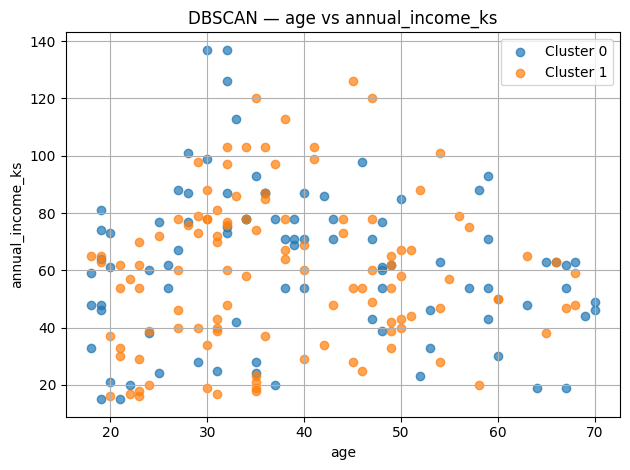

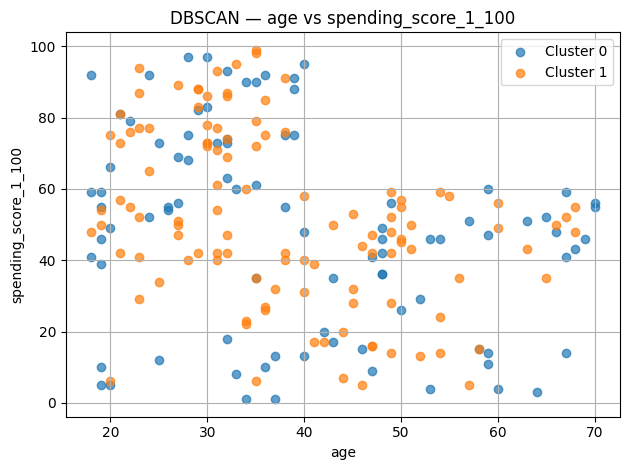

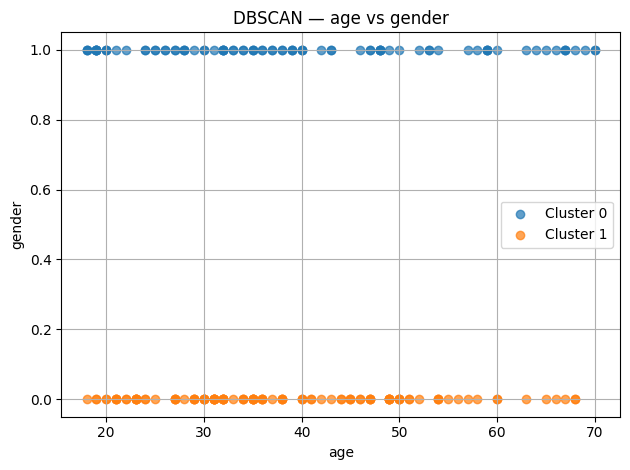

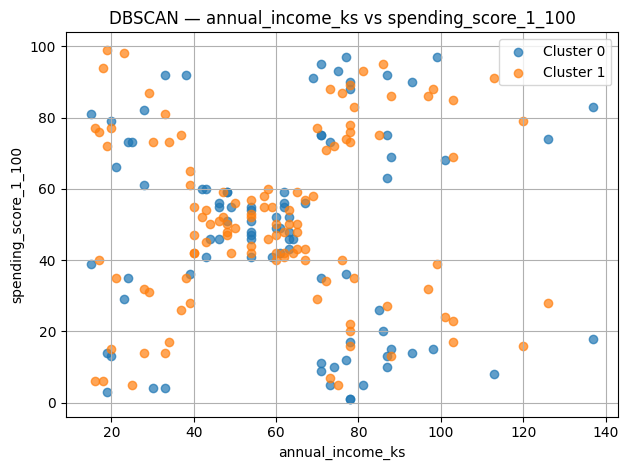

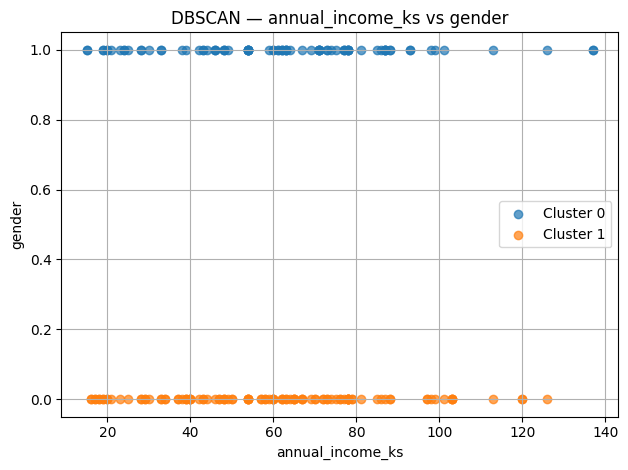

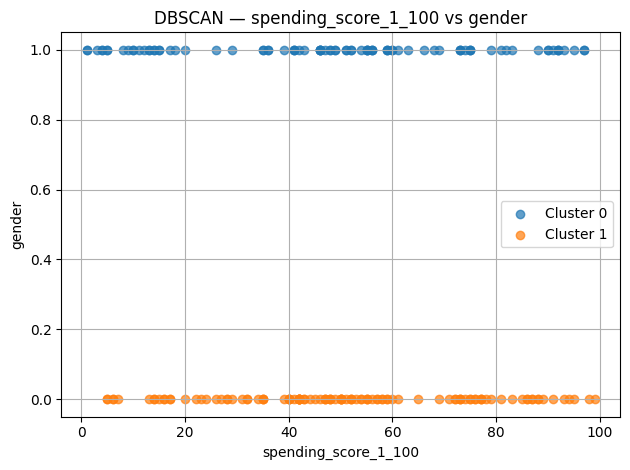

In [46]:
if best_labels is not None:
    df["dbscan_cluster"] = best_labels
    # 2D plots for DBSCAN on the same pairs
    for xcol, ycol in pairs:
        plt.figure()
        for cl in sorted(set(best_labels)):
            mask = best_labels == cl
            plt.scatter(df.loc[mask, xcol], df.loc[mask, ycol], alpha=0.7, label=f"Cluster {cl}")
        plt.title(f"DBSCAN — {xcol} vs {ycol}")
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [47]:
import joblib
joblib.dump(km, 'task2_mall_customer_segmentation.pkl')

['task2_mall_customer_segmentation.pkl']

In [40]:
import os
print(os.getcwd())

C:\Users\Administrator\AppData\Local\Programs\Python\Python313\Scripts
